**Author:** Raoul Malm  

**Abstract:** 

Implementing different multilayer perceptrons (MLPs) in Tensorflow for simple classification tasks. The key goal here is to get some confidence in visualizing graphs with Tensorboard as well as saving and loading pretrained graphs.

# 1. Introduction and Data Preprocessing

/Users/raoul/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Tensorflow version 1.4.1
Python version 3.6.5 |Anaconda custom (64-bit)| (default, Mar 29 2018, 13:14:23) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
train data shapes:  (2000, 1) (2000, 2)
test data shapes:  (2000, 1) (2000, 2)


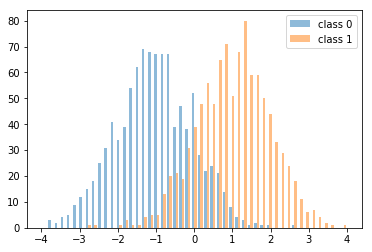

In [2]:
"""
Import libraries and perform data preprocessing.
"""
import tensorflow as tf
import numpy as np
import sys
import matplotlib.pyplot as plt
import datetime
import os
import sklearn.model_selection
import pandas as pd
%matplotlib inline

# Print current python and tensorflow versions.
print('Tensorflow version', tf.__version__)
print('Python version', sys.version)

def dense_to_one_hot(labels_dense, num_classes):
    """Convert dense labels to one-hot-encodings."""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

def one_hot_to_dense(labels_one_hot):
    """Convert one-hot encodings into dense labels."""
    return np.argmax(labels_one_hot,1)

def get_next_mini_batch():
    """Return the next mini batch of training data.
    
    Returns
        x_trn_mb: mini batch of training x values
        y_trn_mb: batch of training y values
    """
    global idx_in_epoch, epoch, ids, x_trn, y_trn
    
    start = idx_in_epoch
    idx_in_epoch += mb_size           
    epoch += mb_size/len(x_trn)

    # At the start of each epoch.
    if start == 0:
        np.random.shuffle(ids)  

    # In case the current index is larger than one epoch.
    if idx_in_epoch > len(x_trn):
        idx_in_epoch = 0
        epoch -= mb_size/len(x_trn) 
        return get_next_mini_batch() # Recursive use of function.

    # Take mini batch from training samples excluding validation samples
    x_trn_mb = x_trn[ids[start:idx_in_epoch]]
    y_trn_mb = y_trn[ids[start:idx_in_epoch]]
    return x_trn_mb, y_trn_mb

# number of training and test samples
n_train = 1000 # train samples per class
n_test = 1000 # test samples per class
n_classes = 2  
r_seed = 123
n_hid_1 = 10

# create distinct classes
np.random.seed(r_seed)
tf.set_random_seed(r_seed)

# create training set
x_train = np.reshape(np.concatenate([np.random.normal(-1,1,n_train), np.random.normal(1,1,n_train)]),(-1,1))
y_train = np.concatenate([np.array([0]*n_train), np.array([1]*n_train)])

# create test set
x_test = np.reshape(np.concatenate([np.random.normal(-1,1,n_test), np.random.normal(1,1,n_test)]),(-1,1))
y_test = np.concatenate([np.array([0]*n_test), np.array([1]*n_test)])

# randomize training and test data
ids = np.arange(len(x_train))
np.random.shuffle(ids)
x_train = x_train[ids]
y_train = y_train[ids]

ids = np.arange(len(x_test))
np.random.shuffle(ids)
x_test = x_test[ids]
y_test = y_test[ids]

# one-hot-encoding
y_train = dense_to_one_hot(y_train, n_classes)
y_test = dense_to_one_hot(y_test, n_classes)

print('train data shapes: ', x_train.shape, y_train.shape)
print('test data shapes: ', x_test.shape, y_test.shape)

# visualize training data
bins = np.linspace(-4, 4, 50)
plt.hist([[x for i,x in enumerate(x_train[:,0]) if y_train[i,0]==1],
         [x for i,x in enumerate(x_train[:,0]) if y_train[i,1]==1]], 
         bins=bins, alpha=0.5, label=['class 0', 'class 1'])
plt.legend(loc='upper right')
plt.show()

# 2. Toy examples

In [65]:
"""
Simple Logistic Regression.
Implementation of Gradient Descent in TensorFlow using tf.gradients
"""
learning_rate = 0.01

tf.reset_default_graph()  
            
# Input layer
x_data_tf = tf.placeholder(tf.float32, [None, 1], 'x_data_tf')
y_data_tf = tf.placeholder(tf.int32, [None, n_classes], 'y_data_tf')

# Output layer
w1_tf = tf.get_variable(shape=[1, n_classes], initializer = tf.contrib.layers.xavier_initializer(), name='w1_tf')
b1_tf = tf.get_variable(shape=[n_classes], initializer = tf.contrib.layers.xavier_initializer(), name='b1_tf')
z1_tf = tf.add(tf.matmul(x_data_tf, w1_tf), b1_tf, name='z1_tf')
a1_tf = tf.nn.softmax(z1_tf, name='a1_tf')

# Loss function
loss_tf = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_data_tf, logits=z1_tf), name='loss_tf')

# Compute gradients.
grad_w1_tf, grad_b1_tf = tf.gradients(xs=[w1_tf, b1_tf], ys=loss_tf)
new_w1_tf = w1_tf.assign(w1_tf - learning_rate * grad_w1_tf)
new_b1_tf = b1_tf.assign(b1_tf - learning_rate * grad_b1_tf)

# Optimization.
#optimize_tf = tf.train.AdamOptimizer(learning_rate=0.11).minimize(loss_tf, name='optimize_tf')

# Tensor of correct predictions
correct_tf = tf.equal(tf.argmax(a1_tf,1), tf.argmax(y_data_tf,1), name='correct_tf')  

# Score: accuracy
score_tf = tf.reduce_mean(tf.cast(correct_tf, dtype=tf.float32), name='score_tf')

with tf.Session() as sess:
    
    # Initialize global variables of graph.
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(20):
        
        # loss and score
        train_loss, train_score = sess.run([loss_tf, score_tf], feed_dict = {x_data_tf:x_train, y_data_tf:y_train})
        valid_loss, valid_score = sess.run([loss_tf, score_tf], feed_dict = {x_data_tf:x_train, y_data_tf:y_train})
        print('{:.3f} epoch: train/valid loss {:.3f}/{:.3f}, train/valid score {:.3f}/{:.3f}'.format(
                        epoch, train_loss, valid_loss, train_score, valid_score))            
        #print(sess.run([w1_tf, b1_tf]))
        
        # Run tf optimizer.
        #sess.run(optimize_tf, feed_dict={x_data_tf: x_train, y_data_tf: y_train})

        # Run own gradient descent.
        sess.run([new_w1_tf, new_b1_tf], feed_dict={x_data_tf: x_train, y_data_tf: y_train})
        


0.000 epoch: train/valid loss 0.348/0.348, train/valid score 0.854/0.854
1.000 epoch: train/valid loss 0.348/0.348, train/valid score 0.854/0.854
2.000 epoch: train/valid loss 0.348/0.348, train/valid score 0.854/0.854
3.000 epoch: train/valid loss 0.348/0.348, train/valid score 0.854/0.854
4.000 epoch: train/valid loss 0.348/0.348, train/valid score 0.854/0.854
5.000 epoch: train/valid loss 0.348/0.348, train/valid score 0.854/0.854
6.000 epoch: train/valid loss 0.348/0.348, train/valid score 0.854/0.854
7.000 epoch: train/valid loss 0.348/0.348, train/valid score 0.854/0.854
8.000 epoch: train/valid loss 0.348/0.348, train/valid score 0.854/0.854
9.000 epoch: train/valid loss 0.347/0.347, train/valid score 0.854/0.854
10.000 epoch: train/valid loss 0.347/0.347, train/valid score 0.854/0.854
11.000 epoch: train/valid loss 0.347/0.347, train/valid score 0.854/0.854
12.000 epoch: train/valid loss 0.347/0.347, train/valid score 0.854/0.854
13.000 epoch: train/valid loss 0.347/0.347, trai

# 3. Build the graph from scratch and perform MLP classification

In [5]:
"""
Build the graph from scratch and perform sophisticated MLP classification.
"""

learn_rate = 0.001            # learn rate
idx_in_epoch = 0              # current index in epoch
mb_size = 50                  # mini batch size
epoch = 0.                    # current epoch

def get_variable(shape, name=None):
    """Weight or bias initialization."""
    #return tf.Variable(tf.random_normal(shape=shape, stddev=0.1),name=name)
    #return tf.Variable(tf.truncated_normal(shape=shape, stddev=0.1),name=name)
    #initializer = tf.contrib.layers.variance_scaling_initializer()
    initializer = tf.contrib.layers.xavier_initializer()
    return tf.get_variable(name=name, shape=shape, initializer=initializer)

tf.reset_default_graph()  
#graph = tf.Graph()
#with graph.as_default():
            
# Input layer
x_data_tf = tf.placeholder(tf.float32, [None, 1], 'x_data_tf')
y_data_tf = tf.placeholder(tf.int32, [None, n_classes], 'y_data_tf')

# Hidden layer
w1_tf = get_variable(shape=[1, n_hid_1], name='w1_tf')
b1_tf = get_variable(shape=[n_hid_1], name='b1_tf')
z1_tf = tf.add(tf.matmul(x_data_tf, w1_tf), b1_tf, name='z1_tf')
a1_tf = tf.nn.relu(z1_tf, name='a1_tf')

# Output layer
w2_tf = get_variable(shape=[n_hid_1, n_classes], name='w2_tf')
b2_tf = get_variable(shape=[n_classes], name='b2_tf')
z2_tf = tf.add(tf.matmul(a1_tf, w2_tf), b2_tf, name='z2_tf')

# Softmax result in terms of probablities ("one-hot" encoding)
y_prob_tf = tf.nn.softmax(z2_tf, name='y_prob_tf')

# Dense results in terms of classes (dense encoding)
y_class_tf = tf.argmax(y_prob_tf, 1, name='y_class_tf')

# Loss function
loss_tf = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_data_tf, logits=z2_tf), name='loss_tf')
#loss_tf = tf.reduce_mean(tf.losses.mean_squared_error(labels=y_data_tf, predictions=y_prob_tf), name='loss_tf')

# Optimization.
optimize_tf = tf.train.AdamOptimizer(learning_rate=learn_rate).minimize(loss_tf, name='optimize_tf')
#optimize_tf = tf.train.RMSPropOptimizer(learning_rate=learn_rate).minimize(loss_tf, name='optimize_tf')

# Tensor of correct predictions
correct_tf = tf.equal(y_class_tf, tf.argmax(y_data_tf,1), name='correct_tf')  

# Score: accuracy
score_tf = tf.reduce_mean(tf.cast(correct_tf, dtype=tf.float32), name='score_tf')

# add summaries to tf tensors for tensorboard
tf.summary.scalar('loss_tf', loss_tf)
tf.summary.scalar('score_tf', score_tf)
merged_tf = tf.summary.merge_all()

with tf.Session() as sess:

    # Saver object for saving the graph and session
    saver_tf = tf.train.Saver()
    
    # Initialize summary writer for tensorboard
    timestamp = datetime.datetime.now().strftime('%d-%m-%Y_%H-%M-%S')
    train_writer_tf = tf.summary.FileWriter(os.path.join(os.getcwd(),'logs',timestamp,'train'), sess.graph)
    valid_writer_tf = tf.summary.FileWriter(os.path.join(os.getcwd(),'logs',timestamp,'valid'), sess.graph)
    
    # Initialize global variables of graph
    sess.run(tf.global_variables_initializer())
    
    # Use 10-fold cross validation.
    cv_num = 10
    kfold = sklearn.model_selection.KFold(cv_num, shuffle=True, random_state=r_seed)

    for i,(train_ids, valid_ids) in enumerate(kfold.split(x_train)):
        
        # Samples used for training and evaluation
        x_trn = x_train[train_ids]
        y_trn = y_train[train_ids]
        x_vld = x_train[valid_ids]
        y_vld = y_train[valid_ids]
        
        # Reset global parameters. 
        epoch = 0.
        idx_in_epoch = 0
        ids = np.arange(len(x_trn))
        
        # Train the MLP classifier
        for n in range(int(20*len(x_trn)/mb_size)):

            x_batch, y_batch = get_next_mini_batch()
            sess.run(optimize_tf, feed_dict={x_data_tf: x_batch, y_data_tf: y_batch})

            # evaluate all summaries attached to tensors and save them
            summary = sess.run(merged_tf, feed_dict = {x_data_tf:x_batch, y_data_tf:y_batch})
            train_writer_tf.add_summary(summary, n)
            summary = sess.run(merged_tf, feed_dict = {x_data_tf:x_vld, y_data_tf:y_vld})
            valid_writer_tf.add_summary(summary, n)
            
            if n%int(1*len(x_trn)/mb_size)==0:
                train_loss, train_score = sess.run([loss_tf, score_tf],
                                                   feed_dict = {x_data_tf:x_batch, y_data_tf:y_batch})
                valid_loss, valid_score = sess.run([loss_tf, score_tf],
                                                   feed_dict = {x_data_tf:x_vld, y_data_tf:y_vld})
                print('{:.3f} epoch: train/valid loss {:.3f}/{:.3f}, train/valid score {:.3f}/{:.3f}'.format(
                    epoch, train_loss, valid_loss, train_score, valid_score))
                
        break
        
    # Save graph and session
    saver_tf.save(sess, os.path.join(os.getcwd(), 'saves', 'mlp_layer_1'))
    
    # Close summary writer for tensorboard
    train_writer_tf.close()
    valid_writer_tf.close()

0.028 epoch: train/valid loss 0.782/0.734, train/valid score 0.440/0.495
1.028 epoch: train/valid loss 0.652/0.612, train/valid score 0.620/0.665
2.028 epoch: train/valid loss 0.518/0.521, train/valid score 0.760/0.780
3.028 epoch: train/valid loss 0.468/0.457, train/valid score 0.760/0.805
4.028 epoch: train/valid loss 0.410/0.416, train/valid score 0.840/0.840
5.028 epoch: train/valid loss 0.387/0.392, train/valid score 0.860/0.855
6.028 epoch: train/valid loss 0.257/0.378, train/valid score 0.940/0.855
7.028 epoch: train/valid loss 0.388/0.370, train/valid score 0.800/0.850
8.028 epoch: train/valid loss 0.382/0.366, train/valid score 0.840/0.850
9.028 epoch: train/valid loss 0.378/0.365, train/valid score 0.820/0.855
10.028 epoch: train/valid loss 0.265/0.364, train/valid score 0.880/0.855
11.028 epoch: train/valid loss 0.305/0.364, train/valid score 0.880/0.855
12.028 epoch: train/valid loss 0.342/0.365, train/valid score 0.880/0.850
13.028 epoch: train/valid loss 0.495/0.365, trai

In [6]:
# use Tensorboard for visualization
if True:
    !tensorboard --logdir=./logs

/Users/raoul/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
2018-07-29 13:50:20.108445: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
TensorBoard 1.7.0 at http://Raouls-MBP.fritz.box:6006 (Press CTRL+C to quit)
^C


# 4. Load an existing graph and test its predictions.

In [40]:
"""
Load an existing graph and test its predictions.
"""

# Reset current graph.
tf.reset_default_graph()

# Load existing graph.
filepath = os.path.join('.', 'saves', 'mlp_layer_1')
saver_tf = tf.train.import_meta_graph(filepath + '.meta')

# Load tensors from graph.
graph = tf.get_default_graph() # save default graph
x_data_tf = graph.get_tensor_by_name("x_data_tf:0")
y_data_tf = graph.get_tensor_by_name("y_data_tf:0")
loss_tf = graph.get_tensor_by_name("loss_tf:0")
score_tf = graph.get_tensor_by_name("score_tf:0")
y_class_tf = graph.get_tensor_by_name("y_class_tf:0")

# Create new session with loaded graph.
sess = tf.Session() # default session
saver_tf.restore(sess, filepath) # restore session

# Predictions of loaded graph.
y_train_pred, train_loss, train_score = sess.run([y_class_tf, loss_tf, score_tf], 
                                                 feed_dict={x_data_tf:x_train, y_data_tf:y_train})
y_test_pred, test_loss, test_score = sess.run([y_class_tf, loss_tf, score_tf], 
                                              feed_dict={x_data_tf:x_test, y_data_tf:y_test})

# Print losses and scores.
print('\nPredictions of loaded graph:\ntrain/test loss {:.3f}/{:.3f}, train/test score {:.3f}/{:.3f}'.format(
    train_loss, test_loss, train_score, test_score))

# Confusion matrices.
y_truth = pd.Series(y_train_pred, name='Truth')
y_pred = pd.Series(one_hot_to_dense(y_train), name='Prediction')
df_confusion = pd.crosstab(y_truth, y_pred)
print('\nConfusion matrix for training samples:')
print(df_confusion)

y_truth = pd.Series(y_test_pred, name='Truth')
y_pred = pd.Series(one_hot_to_dense(y_test), name='Prediction')
df_confusion = pd.crosstab(y_truth, y_pred)
print('\nConfusion matrix for test samples:')
print(df_confusion)

sess.close()

INFO:tensorflow:Restoring parameters from ./saves/mlp_layer_1

Predictions of loaded graph:
train/test loss 0.991/0.986, train/test score 0.500/0.500

Confusion matrix for training samples:
Prediction     0     1
Truth                 
1           1000  1000

Confusion matrix for test samples:
Prediction     0     1
Truth                 
1           1000  1000


# 5. Load an existing graph, extend it by one layer and retrain the entire graph

In [4]:
"""
Load an existing graph and extend the graph by one additional layer.
"""

learn_rate = 0.001            # learn rate
idx_in_epoch = 0              # current index in epoch
mb_size = 50                  # mini batch size
epoch = 0.                    # current epoch
n_hid2 = 10  

def initialize_uninitialized(sess):
    """Initialize unitialized variables"""
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]
    print('Initialize: ',[str(i.name) for i in not_initialized_vars])
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))

# Reset current graph.
tf.reset_default_graph()

# Load existing graph.
filepath = os.path.join('.', 'saves', 'mlp_layer_1')
saver_tf = tf.train.import_meta_graph(filepath + '.meta')

# Load tensors from graph.
graph = tf.get_default_graph() # save default graph
a1_tf = graph.get_tensor_by_name('a1_tf:0')
y_data_tf = graph.get_tensor_by_name('y_data_tf:0')
x_data_tf = graph.get_tensor_by_name('x_data_tf:0')

# Fix a1_tf, i.e. no gradient descent beyond this point.
# Otherwise, the whole graph will be retrained
#a1_tf = tf.stop_gradient(a1_tf)

# Additional second layer.
w2_tf = tf.Variable(tf.truncated_normal([a1_tf.shape[1].value,n_hid2], stddev=0.1), name='w2_tf')
b2_tf = tf.Variable(tf.truncated_normal([n_hid2], stddev=0.1), name='b2_tf')
z2_tf = tf.add(tf.matmul(a1_tf,w2_tf), b2_tf, name='z2_tf')
a2_tf = tf.nn.relu(z2_tf, name='a2_tf')

# Output layer.
w3_tf = tf.Variable(tf.truncated_normal([a2_tf.shape[1].value,n_classes], stddev=0.1), name='w3_tf')
b3_tf = tf.Variable(tf.truncated_normal([n_classes], stddev=0.1), name='b3_tf')
z3_tf = tf.add(tf.matmul(a2_tf,w3_tf), b3_tf, name='z3_tf')

# Softmax result in terms of probablities ("one-hot" encoding)
y_prob_tf = tf.nn.softmax(z3_tf, name='y_prob_tf')

# Dense results in terms of classes (dense encoding)
y_class_tf = tf.argmax(y_prob_tf, 1, name='y_class_tf')

# Loss function
loss_tf = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_data_tf, logits=z3_tf), name='loss_tf')

# Optimization.
#optimize_tf = tf.train.AdamOptimizer(learning_rate=learn_rate).minimize(loss_tf, name='optimize_tf')
optimize_tf = tf.train.RMSPropOptimizer(learning_rate=learn_rate).minimize(loss_tf, name='optimize_tf')

# Tensor of correct predictions
correct_tf = tf.equal(y_class_tf, tf.argmax(y_data_tf,1), name='correct_tf')  

# Score: accuracy
score_tf = tf.reduce_mean(tf.cast(correct_tf, dtype=tf.float32), name='score_tf')

# Create new session with loaded graph.
sess = tf.Session() # default session
saver_tf.restore(sess, filepath) # restore session

# Initialize only uninitialized variables
initialize_uninitialized(sess)

# Use 10-fold cross validation.
cv_num = 10
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True, random_state=r_seed)

for i,(train_ids, valid_ids) in enumerate(kfold.split(x_train)):

    # Samples used for training and evaluation
    x_trn = x_train[train_ids]
    y_trn = y_train[train_ids]
    x_vld = x_train[valid_ids]
    y_vld = y_train[valid_ids]

    # Reset global parameters. 
    epoch = 0.
    idx_in_epoch = 0
    ids = np.arange(len(x_trn))

    # Train the MLP classifier
    for n in range(int(20*len(x_trn)/mb_size)):

        x_batch, y_batch = get_next_mini_batch()
        sess.run(optimize_tf, feed_dict={x_data_tf: x_batch, y_data_tf: y_batch})

        if n%int(1*len(x_trn)/mb_size)==0:
            train_loss, train_score = sess.run([loss_tf, score_tf],
                                               feed_dict = {x_data_tf:x_batch, y_data_tf:y_batch})
            valid_loss, valid_score = sess.run([loss_tf, score_tf],
                                               feed_dict = {x_data_tf:x_vld, y_data_tf:y_vld})
            print('{:.3f} epoch: train/valid loss {:.3f}/{:.3f}, train/valid score {:.3f}/{:.3f}'.format(
                epoch, train_loss, valid_loss, train_score, valid_score))
    break

# Predictions of loaded graph.
y_train_pred, train_loss, train_score = sess.run([y_class_tf, loss_tf, score_tf], 
                                                 feed_dict={x_data_tf:x_train, y_data_tf:y_train})
y_test_pred, test_loss, test_score = sess.run([y_class_tf, loss_tf, score_tf], 
                                              feed_dict={x_data_tf:x_test, y_data_tf:y_test})
# Print losses and scores.
print('\nPredictions of loaded graph:\ntrain/test loss {:.3f}/{:.3f}, train/test score {:.3f}/{:.3f}'.format(
    train_loss, test_loss, train_score, test_score))

sess.close()


INFO:tensorflow:Restoring parameters from ./saves/mlp_layer_1
Initialize:  ['w2_tf_1:0', 'b2_tf_1:0', 'w3_tf:0', 'b3_tf:0', 'w1_tf/RMSProp:0', 'w1_tf/RMSProp_1:0', 'b1_tf/RMSProp:0', 'b1_tf/RMSProp_1:0', 'w2_tf_1/RMSProp:0', 'w2_tf_1/RMSProp_1:0', 'b2_tf_1/RMSProp:0', 'b2_tf_1/RMSProp_1:0', 'w3_tf/RMSProp:0', 'w3_tf/RMSProp_1:0', 'b3_tf/RMSProp:0', 'b3_tf/RMSProp_1:0']
0.028 epoch: train/valid loss 0.696/0.699, train/valid score 0.520/0.490
1.028 epoch: train/valid loss 0.696/0.697, train/valid score 0.520/0.490
2.028 epoch: train/valid loss 0.687/0.688, train/valid score 0.700/0.720
3.028 epoch: train/valid loss 0.661/0.662, train/valid score 0.860/0.820
4.028 epoch: train/valid loss 0.611/0.601, train/valid score 0.780/0.825
5.028 epoch: train/valid loss 0.466/0.522, train/valid score 0.920/0.830
6.028 epoch: train/valid loss 0.427/0.449, train/valid score 0.880/0.835
7.028 epoch: train/valid loss 0.430/0.401, train/valid score 0.740/0.830
8.028 epoch: train/valid loss 0.333/0.374, t

# 5. Try out other Classifiers

In [30]:
"""
Try different other classifiers.
"""

import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble

## First try out some basic sklearn models
logreg = sklearn.linear_model.LogisticRegression(verbose=0, solver='lbfgs', multi_class='multinomial')
decision_tree = sklearn.tree.DecisionTreeClassifier()
extra_trees = sklearn.ensemble.ExtraTreesClassifier(verbose=0)
gradient_boost = sklearn.ensemble.GradientBoostingClassifier(verbose=0)
random_forest = sklearn.ensemble.RandomForestClassifier(verbose=0)
gaussianNB = sklearn.naive_bayes.GaussianNB()

# store models in dictionary
base_models = {'logreg': logreg, 'extra_trees': extra_trees,
               'gradient_boost': gradient_boost, 'random_forest': random_forest, 
               'decision_tree': decision_tree, 'gaussianNB': gaussianNB}

# choose models for out-of-folds predictions
take_models = ['logreg','random_forest','extra_trees', 'gradient_boost', 'decision_tree', 'gaussianNB']

# Cross validations.
cv_num = 10  
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True, random_state=r_seed)

for i,(train_ids, valid_ids) in enumerate(kfold.split(x_train)):

    # Samples used for training and evaluation.
    x_trn = x_train[train_ids]
    y_trn = y_train[train_ids]
    x_vld = x_train[valid_ids]
    y_vld = y_train[valid_ids]
    
    for mn in take_models:

        # Create cloned model from base models.
        model = sklearn.base.clone(base_models[mn])
        model.fit(x_trn, one_hot_to_dense(y_trn))

        # Predictions.
        y_train_pred = model.predict(x_trn)
        y_valid_pred = model.predict(x_vld)
        
        print('{}: train/valid accuracy = {:.3f}/{:.3f}'.format(mn, np.mean(y_train_pred == np.argmax(y_trn,1)),
                                                  np.mean(y_valid_pred == np.argmax(y_vld,1))))
    
    break;


logreg: train/valid accuracy = 0.851/0.845
random_forest: train/valid accuracy = 0.979/0.800
extra_trees: train/valid accuracy = 1.000/0.780
gradient_boost: train/valid accuracy = 0.877/0.840
decision_tree: train/valid accuracy = 1.000/0.795
gaussianNB: train/valid accuracy = 0.851/0.835
